<a href="https://colab.research.google.com/github/johanesPao/tensorflow_developer_certificate/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit 📰🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

📖 **Resource:** If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Confirm access to GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d8bfd104-add8-971e-74c9-28a37f93b4d4)


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sig
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best wats to become one with the data is to...

> Visualize, visualize, visualize

So with that in mind, let's write a function to read in all of the lines of a target text file

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt") # read the line with the training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
  'total_lines': 11},
  ...]
```

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, read it contents and sorts through each line,
  extracting things like the target label, the text of the sentence, 
  how many sentences are in the current abstract and what sentence 
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
      
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate line

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract?
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfillled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 741 ms, sys: 112 ms, total: 852 ms
Wall time: 1.28 s


In [11]:
# Check the first abstract of our training data
train_samples[:30]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

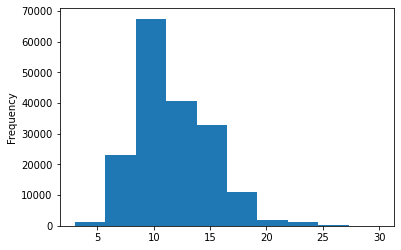

In [14]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get list of sentences

In [15]:
# Convert abstract text line into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [17]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [18]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as alwaysm we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model 0: Getting a baseline

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script

In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather tahn rewriting it here, let's download it from our helper function script.

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-25 15:13:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-25 15:13:09 (95.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

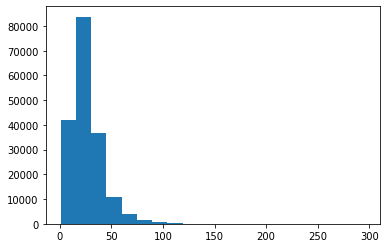

In [28]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [29]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [31]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [32]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [33]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text:
we used data from @ countries participating in the ascend-hf trial .

Length of text: 12

Vectorized text: [[   43    98   100    27  1214  1466     5     2 12257    32     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [35]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding

In [37]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space)
                               name='token_embedding')

In [38]:
# Show example embedding
print(f'Sentence before vectorization:\n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization (before embedding):\n {vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization:
 we used data from @ countries participating in the ascend-hf trial .

Sentence after vectorization (before embedding):
 [[   43    98   100    27  1214  1466     5     2 12257    32     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.0477466   0.04817346  0.02845324 ... -0.01807345 -0.004318
   -0.00844395]
  [-0.03916441 -0.00897939  0.03928765 ... -0.0318314  -0.03504728
    0.00023693]
  [-0.01104655 -0.02514178  0.03491959 ... -0.02385714 -0.00558509
    0.01038025]
  ...
  [-0.03344093 -0.01896792  0.00839853 ... -0.02082449 -0.01443645
    0.01965206]
  [-0.03344093 -0.01896792  0.00839853 ... -0.02082449 -0.01443645
    0.01965206]
  [-0.03344093 -0.01896792  0.00839853 ... -0.02082449 -0.0

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [39]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [41]:
# Take the TensorSliceDataset's and turn them into prefetched dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [42]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [43]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 output_layer (Dense)        (None, 5)                 325   

In [44]:
# Prepare wandb for notebook in Google Colab
!pip install wandb
import wandb as wb
from wandb.keras import WandbCallback

# wb login
wb.login(key='924d78a46727fe1fb5374706bf1b8a158fe73971')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.0 MB/s 
     |████████████████████████████████| 181 kB 59.1 MB/s 
     |████████████████████████████████| 145 kB 53.8 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=3b8b7a7123e9bd4be634d34fde4f9b603dfb0c65bcb82b843738c68bbf64d864
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [45]:
# wb model_1 init and config
wb.init(project='SkimLit',
        entity='jpao',
        name='model_1_conv1D',
        config={'n_layers': len(model_1.layers),
                'steps_multiplier': 0.1, 
                'epochs': 3})

wandb: Currently logged in as: jpao. Use `wandb login --relogin` to force relogin


In [46]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              epochs=wb.config.epochs,
                              steps_per_epoch=int(wb.config.steps_multiplier * len(train_dataset)), # only look at 10% of the batch to make it run faster initially
                              validation_data=valid_dataset,
                              validation_steps=int(wb.config.steps_multiplier * len(valid_dataset)), # only validate on 10% of batches
                              callbacks=[WandbCallback(save_model=False)])

Epoch 1/3
562/562 [==============================] - 24s 15ms/step - loss: 0.9235 - accuracy: 0.6326 - val_loss: 0.6869 - val_accuracy: 0.7400 - _timestamp: 1656170062.0000 - _runtime: 26.0000
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.6607 - accuracy: 0.7551 - val_loss: 0.6312 - val_accuracy: 0.7680 - _timestamp: 1656170069.0000 - _runtime: 33.0000
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6221 - accuracy: 0.7733 - val_loss: 0.6006 - val_accuracy: 0.7856 - _timestamp: 1656170074.0000 - _runtime: 38.0000


In [47]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6045 - accuracy: 0.7838


[0.6045346856117249, 0.7837614417076111]

In [48]:
# Make predictions (our model predicts prediction probabilites for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.3330181e-01, 1.7529368e-01, 9.8116226e-02, 2.6423991e-01,
         2.9048376e-02],
        [4.6667317e-01, 2.2998649e-01, 1.3146175e-02, 2.8400218e-01,
         6.1918912e-03],
        [1.3527256e-01, 1.2830159e-02, 1.6939718e-03, 8.5016477e-01,
         3.8607988e-05],
        ...,
        [3.1804241e-06, 9.0008182e-04, 5.7617843e-04, 2.5430606e-06,
         9.9851805e-01],
        [5.2978128e-02, 4.3995953e-01, 1.3563195e-01, 7.0420153e-02,
         3.0101022e-01],
        [1.8626848e-01, 6.2539637e-01, 2.7512506e-02, 4.5866776e-02,
         1.1495579e-01]], dtype=float32), (30212, 5))

In [49]:
# Convert pred_probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [50]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.3761419303588,
 'f1': 0.7813325115121339,
 'precision': 0.7805444570358488,
 'recall': 0.783761419303588}

In [51]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings grom TensorFlow Hub, more specifically the Universal Sentence Encoder (USE): https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later create USE pretrained embeddings.

In [52]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [53]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence:\n {random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n')
print(f'Length of sentence embedding: {len(use_embedded_sentence[0])}')

Random sentence:
 in breast cancer survivors with dyspareunia , exquisite sensitivity was vestibular and reversible with aqueous lidocaine .
Sentence after embedding:
[-0.04997348  0.0654007  -0.04859557 -0.0213088   0.0168644  -0.05968301
 -0.04191997 -0.04964077  0.05968302  0.02388411  0.08235232 -0.06294698
  0.0286042   0.0581217   0.04313808 -0.03671195 -0.08401806  0.03570003
  0.03748647  0.07747883 -0.0283208   0.07247464  0.0704743  -0.02019826
  0.04593732  0.07522018 -0.06564105  0.02088416  0.00901941  0.07595067]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [54]:
# Create Conv1D model with USE pretrained embedding layer
inputs = layers.Input(shape=[], dtype=tf.string, name='input_layer')
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_USE_feature_extractor')

In [55]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [56]:
# Compile the mode
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Setup wandb init and config
wb.init(project='SkimLit',
        entity='jpao',
        name='model_2_USE_feature_extractor',
        config={'n_layers': len(model_2.layers),
                'steps_multiplier': 0.1, 
                'epochs': 3})

accuracy,▁▇█
epoch,▁▅█
loss,█▂▁
val_accuracy,▁▅█
val_loss,█▃▁
accuracy,0.7733
best_epoch,2
best_val_loss,0.60056
epoch,2
loss,0.62215
val_accuracy,0.78557


In [57]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              epochs=wb.config.epochs,
                              steps_per_epoch=int(wb.config.steps_multiplier * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(wb.config.steps_multiplier * len(valid_dataset)),
                              callbacks=[WandbCallback(save_model=False)])

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9165 - accuracy: 0.6512 - val_loss: 0.7992 - val_accuracy: 0.6888 - _timestamp: 1656170114.0000 - _runtime: 12.0000
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7705 - accuracy: 0.7009 - val_loss: 0.7593 - val_accuracy: 0.7028 - _timestamp: 1656170121.0000 - _runtime: 19.0000
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7563 - accuracy: 0.7105 - val_loss: 0.7459 - val_accuracy: 0.7114 - _timestamp: 1656170128.0000 - _runtime: 26.0000


In [58]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7463 - accuracy: 0.7120


[0.7463487982749939, 0.7119687795639038]

In [59]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.2532274e-01, 3.6744463e-01, 2.3809222e-03, 1.9759734e-01,
        7.2543733e-03],
       [3.4663793e-01, 5.1486605e-01, 2.8275510e-03, 1.3228175e-01,
        3.3866842e-03],
       [2.2695497e-01, 1.4215727e-01, 1.9070659e-02, 5.7534248e-01,
        3.6474615e-02],
       ...,
       [2.1721611e-03, 7.6251482e-03, 5.7035603e-02, 8.2491233e-04,
        9.3234217e-01],
       [4.2580860e-03, 4.1994769e-02, 2.0577653e-01, 1.3770494e-03,
        7.4659359e-01],
       [1.6897139e-01, 2.3882106e-01, 5.2089578e-01, 6.0143741e-03,
        6.5297373e-02]], dtype=float32)

In [60]:
# Convert the prediction probabilities found with feature extraction model to label
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [61]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.19687541374289,
 'f1': 0.7091145461585903,
 'precision': 0.711750047122208,
 'recall': 0.7119687541374289}

In [62]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character embeddings.

Previously we've made token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character-level tokenizer

In [63]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [64]:
# Make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'i n   b r e a s t   c a n c e r   s u r v i v o r s   w i t h   d y s p a r e u n i a   ,   e x q u i s i t e   s e n s i t i v i t y   w a s   v e s t i b u l a r   a n d   r e v e r s i b l e   w i t h   a q u e o u s   l i d o c a i n e   .'

In [65]:
# Split sequence-level data splits into characters-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [66]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

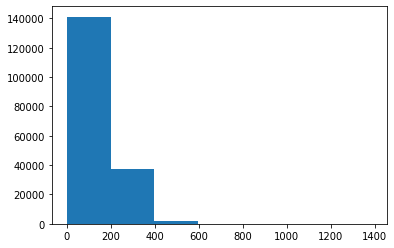

In [67]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [68]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [69]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [70]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None, # set standardization to "None" if you want leave punctuation in
                                    name='char_vectorizer')

In [71]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [72]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [73]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'\nLength of random_train_chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n {vectorized_chars}')
print(f'\nLength of vectorized chars: {len(vectorized_chars[0])}')

Charified text:
 t h e   c o n t r o l   g r o u p   c o n s i s t e d   o f   f i f t y   p a t i e n t s   f e d   i n   s t a n d a r d   m a n n e r   p e r   o s   (   t h r e e   s t a n d a r d   h o s p i t a l   m e a l s   )   i m m e d i a t e l y   a f t e r   t h e   f i r s t   w o u n d   d r e s s i n g   .

Length of random_train_chars: 129

Vectorized chars:
 [[ 3 13  2 11  7  6  3  8  7 12 18  8  7 16 14 11  7  6  9  4  9  3  2 10
   7 17 17  4 17  3 19 14  5  3  4  2  6  3  9 17  2 10  4  6  9  3  5  6
  10  5  8 10 15  5  6  6  2  8 14  2  8  7  9  3 13  8  2  2  9  3  5  6
  10  5  8 10 13  7  9 14  4  3  5 12 15  2  5 12  9  4 15 15  2 10  4  5
   3  2 12 19  5 17  3  2  8  3 13  2 17  4  8  9  3 20  7 16  6 10 10  8
   2  9  9  4  6 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0

## Creating a character-level embedding

In [74]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                              mask_zero=True,
                              name='char_embed')

In [75]:
# Test our character embedding layer
print(f'Charified text:\n {random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars (after vectorization and embedding):\n {char_embed_example}\n')
print(f'Character embedding shape: {char_embed_example.shape}')

Charified text:
 t h e   c o n t r o l   g r o u p   c o n s i s t e d   o f   f i f t y   p a t i e n t s   f e d   i n   s t a n d a r d   m a n n e r   p e r   o s   (   t h r e e   s t a n d a r d   h o s p i t a l   m e a l s   )   i m m e d i a t e l y   a f t e r   t h e   f i r s t   w o u n d   d r e s s i n g   .

Embedded chars (after vectorization and embedding):
 [[[ 0.04388246 -0.03440835  0.00023489 ...  0.01856944 -0.03982005
   -0.04671443]
  [ 0.03162351 -0.0149166   0.00640236 ... -0.0065464  -0.01629969
    0.01001606]
  [ 0.00462303  0.03526921  0.01493705 ...  0.00710298 -0.04326109
    0.0313481 ]
  ...
  [-0.0025475  -0.04274465  0.01064087 ... -0.00490987  0.02555272
    0.04007906]
  [-0.0025475  -0.04274465  0.01064087 ... -0.00490987  0.02555272
    0.04007906]
  [-0.0025475  -0.04274465  0.01064087 ... -0.00490987  0.02555272
    0.04007906]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [76]:
# Create a Conv1D with character-level embedded
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_conv1d_char_embeddings')

In [77]:
# Compile
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [78]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 

In [79]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [80]:
# Setup wandb init and config
wb.init(project='SkimLit',
        entity='jpao',
        name='model_3_conv1d_char_embeddings_max_pool',
        config={'n_layers': len(model_3.layers),
                'epochs': 3,
                'steps_multiplier': 0.1})

# Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                              epochs=wb.config.epochs,
                              steps_per_epoch=int(wb.config.steps_multiplier * len(train_char_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(wb.config.steps_multiplier * len(val_char_dataset)),
                              callbacks=[WandbCallback()])

accuracy,▁▇█
epoch,▁▅█
loss,█▂▁
val_accuracy,▁▅█
val_loss,█▃▁
accuracy,0.71046
best_epoch,2
best_val_loss,0.74586
epoch,2
loss,0.75627
val_accuracy,0.71144


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/3
555/562 [============================>.] - ETA: 0s - loss: 1.2823 - accuracy: 0.4813

wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.


INFO:tensorflow:Assets written to: /content/wandb/run-20220625_151633-3nz76ivq/files/model-best/assets


INFO:tensorflow:Assets written to: /content/wandb/run-20220625_151633-3nz76ivq/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20220625_151633-3nz76ivq/files/model-best)... Done. 0.1s


562/562 [==============================] - 6s 9ms/step - loss: 1.2786 - accuracy: 0.4830 - val_loss: 1.0506 - val_accuracy: 0.5808 - _timestamp: 1656170202.0000 - _runtime: 6.0000
Epoch 2/3
554/562 [============================>.] - ETA: 0s - loss: 1.0017 - accuracy: 0.5985INFO:tensorflow:Assets written to: /content/wandb/run-20220625_151633-3nz76ivq/files/model-best/assets


INFO:tensorflow:Assets written to: /content/wandb/run-20220625_151633-3nz76ivq/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20220625_151633-3nz76ivq/files/model-best)... Done. 0.1s


562/562 [==============================] - 4s 8ms/step - loss: 1.0006 - accuracy: 0.5993 - val_loss: 0.9510 - val_accuracy: 0.6233 - _timestamp: 1656170207.0000 - _runtime: 11.0000
Epoch 3/3
556/562 [============================>.] - ETA: 0s - loss: 0.9217 - accuracy: 0.6397INFO:tensorflow:Assets written to: /content/wandb/run-20220625_151633-3nz76ivq/files/model-best/assets


INFO:tensorflow:Assets written to: /content/wandb/run-20220625_151633-3nz76ivq/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20220625_151633-3nz76ivq/files/model-best)... Done. 0.1s


562/562 [==============================] - 4s 8ms/step - loss: 0.9213 - accuracy: 0.6397 - val_loss: 0.8684 - val_accuracy: 0.6579 - _timestamp: 1656170212.0000 - _runtime: 16.0000


In [81]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.20069876, 0.32684377, 0.05791162, 0.37764505, 0.03690086],
       [0.16210833, 0.6341746 , 0.06405064, 0.07685123, 0.06281526],
       [0.1284416 , 0.34737137, 0.25011522, 0.18119414, 0.0928777 ],
       ...,
       [0.01046265, 0.02659446, 0.19330737, 0.03789188, 0.73174363],
       [0.02853931, 0.15187341, 0.22800209, 0.05490147, 0.53668374],
       [0.37189767, 0.43417385, 0.09836955, 0.07689673, 0.0186622 ]],
      dtype=float32)

In [82]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 1, ..., 4, 4, 1])>

In [83]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.75201906527208,
 'f1': 0.6468422991479206,
 'precision': 0.6496733461568108,
 'recall': 0.6575201906527208}

In [84]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence level probabilities as output

In [85]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_4_token_and_char_embeddings')

In [86]:
# Get a summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

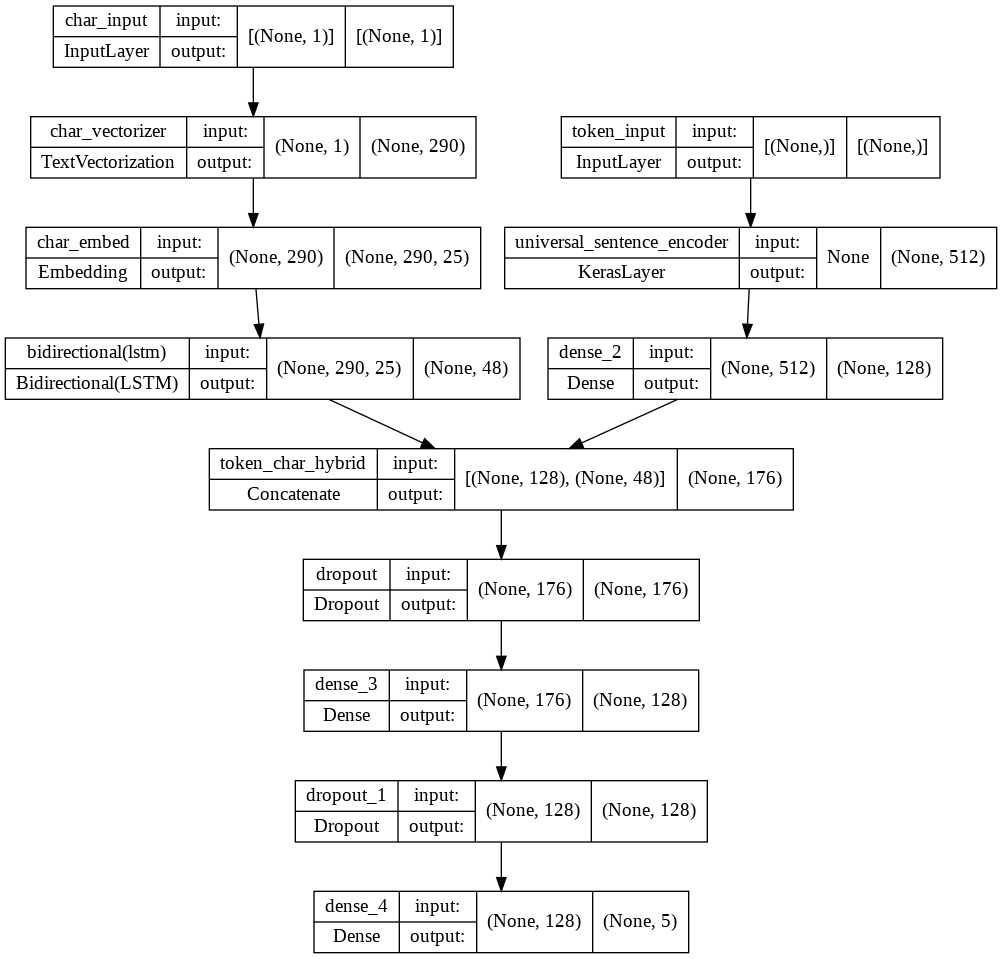

In [87]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [88]:
# Compile token char model
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Combining token and character data into a tf.data Dataset

In [89]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [90]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels

# Prefetch and batch val data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [93]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [94]:
# Create setup for wandb init and config
wb.init(project='SkimLit',
        entity='jpao',
        name='model_4_token_and_char_embeddings',
        config={'n_layers': len(model_4.layers),
                'epochs': 3,
                'steps_multiplier': 0.1})

# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=wb.config.epochs,
                              steps_per_epoch=int(wb.config.steps_multiplier * len(train_char_token_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps=int(wb.config.steps_multiplier * len(val_char_token_dataset)),
                              callbacks=[WandbCallback()])

accuracy,▁▆█
epoch,▁▅█
loss,█▃▁
val_accuracy,▁▅█
val_loss,█▄▁
accuracy,0.63974
best_epoch,2
best_val_loss,0.86839
epoch,2
loss,0.92129
val_accuracy,0.65791


Epoch 1/3
562/562 [==============================] - ETA: 0s - loss: 0.9806 - accuracy: 0.6107

wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.


INFO:tensorflow:Assets written to: /content/wandb/run-20220625_151746-33cqqutk/files/model-best/assets


INFO:tensorflow:Assets written to: /content/wandb/run-20220625_151746-33cqqutk/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20220625_151746-33cqqutk/files/model-best)... Done. 6.3s


562/562 [==============================] - 80s 126ms/step - loss: 0.9806 - accuracy: 0.6107 - val_loss: 0.7801 - val_accuracy: 0.7025 - _timestamp: 1656170313.0000 - _runtime: 43.0000
Epoch 2/3
562/562 [==============================] - ETA: 0s - loss: 0.8003 - accuracy: 0.6929

INFO:tensorflow:Assets written to: /content/wandb/run-20220625_151746-33cqqutk/files/model-best/assets


INFO:tensorflow:Assets written to: /content/wandb/run-20220625_151746-33cqqutk/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20220625_151746-33cqqutk/files/model-best)... Done. 6.2s


562/562 [==============================] - 71s 127ms/step - loss: 0.8003 - accuracy: 0.6929 - val_loss: 0.7159 - val_accuracy: 0.7344 - _timestamp: 1656170384.0000 - _runtime: 114.0000
Epoch 3/3
562/562 [==============================] - ETA: 0s - loss: 0.7751 - accuracy: 0.7071

INFO:tensorflow:Assets written to: /content/wandb/run-20220625_151746-33cqqutk/files/model-best/assets


INFO:tensorflow:Assets written to: /content/wandb/run-20220625_151746-33cqqutk/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20220625_151746-33cqqutk/files/model-best)... Done. 6.3s


562/562 [==============================] - 72s 128ms/step - loss: 0.7751 - accuracy: 0.7071 - val_loss: 0.6890 - val_accuracy: 0.7384 - _timestamp: 1656170454.0000 - _runtime: 184.0000


In [95]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 26s 27ms/step - loss: 0.6931 - accuracy: 0.7359


[0.6931164264678955, 0.7358996272087097]

In [96]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.23851132e-01, 3.48962277e-01, 5.18696010e-03, 2.13038817e-01,
        8.96086916e-03],
       [3.54529291e-01, 4.37613875e-01, 4.76557156e-03, 2.00850233e-01,
        2.24106130e-03],
       [2.23174825e-01, 1.16507694e-01, 4.28840742e-02, 5.78661084e-01,
        3.87723297e-02],
       ...,
       [6.68290188e-04, 9.76736285e-03, 5.07030226e-02, 2.11263730e-04,
        9.38650072e-01],
       [8.31806939e-03, 5.23148812e-02, 2.28291318e-01, 3.37000214e-03,
        7.07705736e-01],
       [2.66513109e-01, 3.06054443e-01, 3.24251860e-01, 3.39908227e-02,
        6.91897497e-02]], dtype=float32)

In [97]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [98]:
# Calculate results
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.58996425261486,
 'f1': 0.7320814419561852,
 'precision': 0.7353983952478104,
 'recall': 0.7358996425261486}

## Model 4: Transfer learnig with pretrained token embeddings + character embeddings + positional embeddings

In [99]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> 🔑 **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [100]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

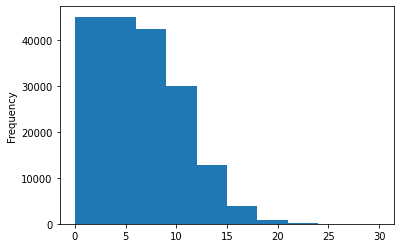

In [101]:
# Check the distribution of "line_number" column
train_df['line_number'].plot.hist()

In [102]:
# Use TensorFlow to create one-hot-encoded tensors of our 'line_number' column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [103]:
# How many total lines number
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

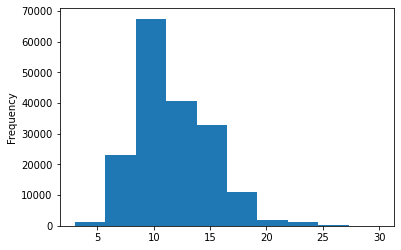

In [104]:
# Plot the distribution of total lines
train_df['total_lines'].plot.hist()

In [105]:
# Check using 98 percentile
total_lines_limit = np.percentile(train_df['total_lines'], 98)
total_lines_limit

20.0

In [106]:
# Use TensorFlow to create one-hot-encoded tensors of our 'total_lines' feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=total_lines_limit)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=total_lines_limit)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=total_lines_limit)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the 'line_number' feature
4. Create a model for the 'total_lines' feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4 & 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into tf.keras.Model

In [107]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,
                            char_bi_lstm)

# 3. Line Numbers input
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                            outputs=x)

# 4. Total Lines input
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combined positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(5, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='model_5_tribrid_embedding_model')

In [108]:
# Get a summary of model_5
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

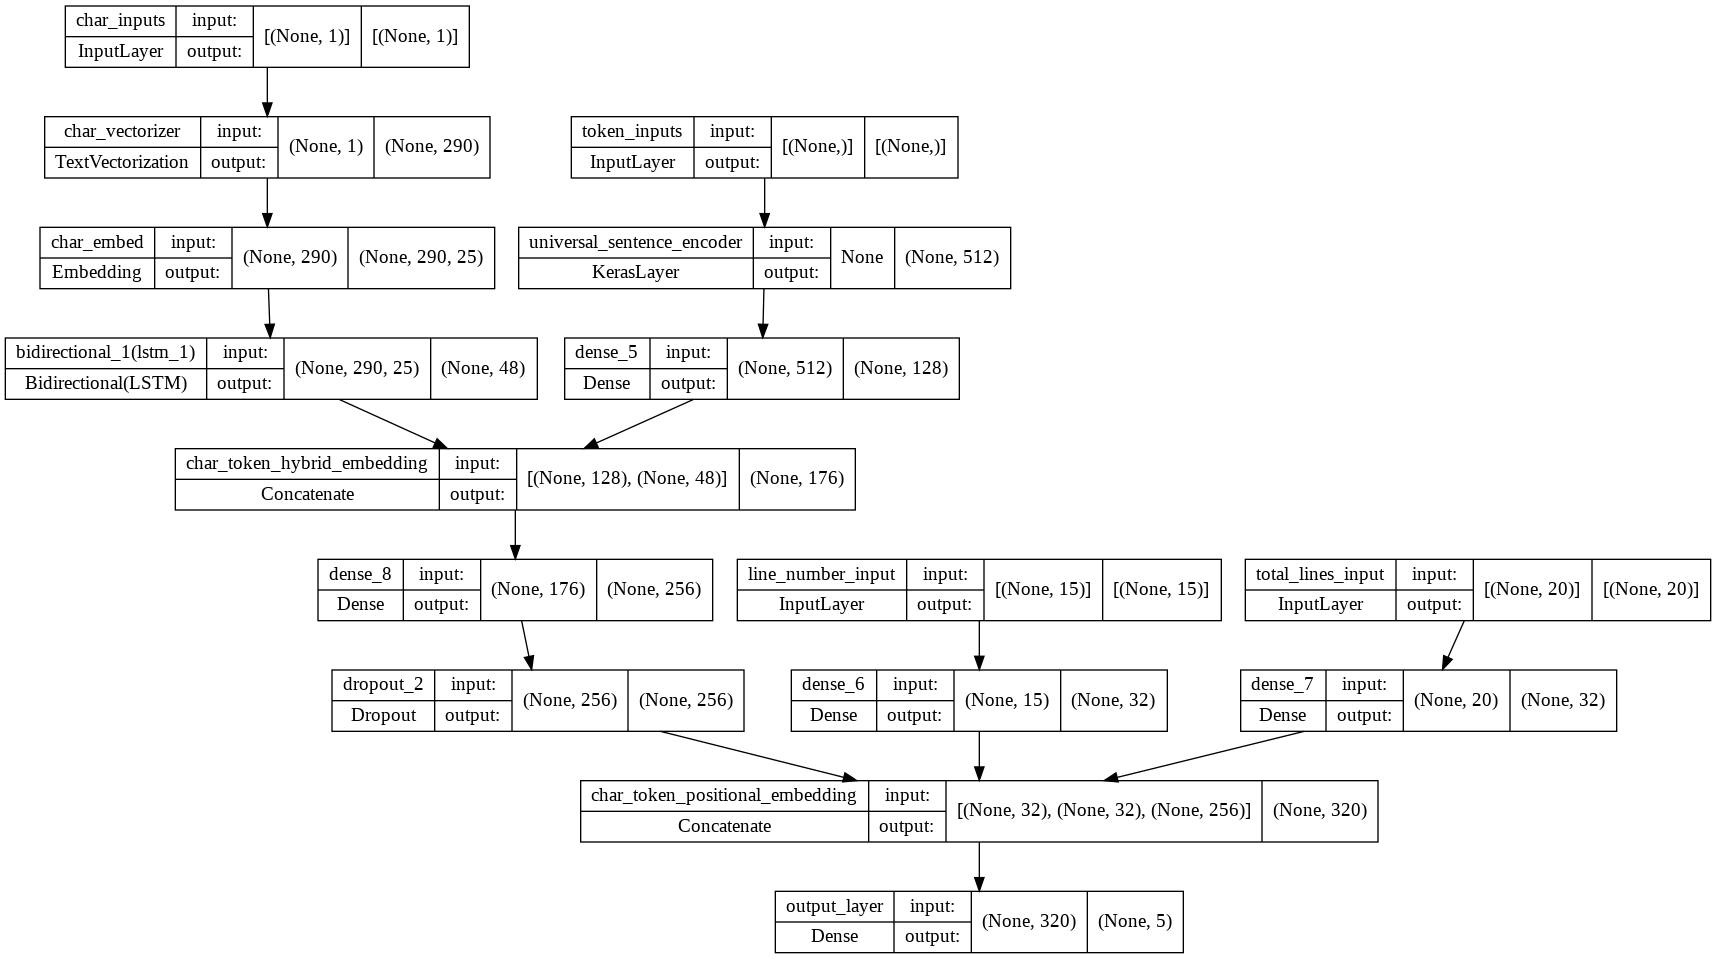

In [109]:
# Show plot of model_5
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothing?

for example if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assign some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

> 📖 **Resource:** for more on label smoothing, see this blog post from PyImageSearch: https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [110]:
# Compile token, char and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Create tribrid embedding datasets using tf.data

In [111]:
# Create training and validation datasets (wtih all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [112]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [113]:
# Setup wandb init and config
wb.init(project='SkimLit',
        entity='jpao',
        name='model_5_tribrid_embedding_model',
        config={'n_layers': len(model_5.layers),
                'epochs': 3,
                'steps_multiplier': 0.1})

# Fit the model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(wb.config.steps_multiplier * len(train_char_token_pos_dataset)),
                              epochs=wb.config.epochs,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(wb.config.steps_multiplier * len(val_char_token_pos_dataset)),
                              callbacks=[WandbCallback()])

accuracy,▁▇█
epoch,▁▅█
loss,█▂▁
val_accuracy,▁▇█
val_loss,█▃▁
accuracy,0.70713
best_epoch,2
best_val_loss,0.68896
epoch,2
loss,0.77512
val_accuracy,0.73836


Epoch 1/3
562/562 [==============================] - ETA: 0s - loss: 1.1009 - accuracy: 0.7182

wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.


INFO:tensorflow:Assets written to: /content/wandb/run-20220625_152229-3pi9dc54/files/model-best/assets


INFO:tensorflow:Assets written to: /content/wandb/run-20220625_152229-3pi9dc54/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20220625_152229-3pi9dc54/files/model-best)... Done. 6.4s


562/562 [==============================] - 82s 132ms/step - loss: 1.1009 - accuracy: 0.7182 - val_loss: 0.9802 - val_accuracy: 0.8102 - _timestamp: 1656170598.0000 - _runtime: 46.0000
Epoch 2/3
561/562 [============================>.] - ETA: 0s - loss: 0.9655 - accuracy: 0.8157

INFO:tensorflow:Assets written to: /content/wandb/run-20220625_152229-3pi9dc54/files/model-best/assets


INFO:tensorflow:Assets written to: /content/wandb/run-20220625_152229-3pi9dc54/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20220625_152229-3pi9dc54/files/model-best)... Done. 6.2s


562/562 [==============================] - 72s 128ms/step - loss: 0.9654 - accuracy: 0.8157 - val_loss: 0.9470 - val_accuracy: 0.8334 - _timestamp: 1656170669.0000 - _runtime: 117.0000
Epoch 3/3
561/562 [============================>.] - ETA: 0s - loss: 0.9495 - accuracy: 0.8225

INFO:tensorflow:Assets written to: /content/wandb/run-20220625_152229-3pi9dc54/files/model-best/assets


INFO:tensorflow:Assets written to: /content/wandb/run-20220625_152229-3pi9dc54/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20220625_152229-3pi9dc54/files/model-best)... Done. 6.2s


562/562 [==============================] - 70s 124ms/step - loss: 0.9495 - accuracy: 0.8225 - val_loss: 0.9377 - val_accuracy: 0.8324 - _timestamp: 1656170739.0000 - _runtime: 187.0000


In [114]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 25s 23ms/step


array([[0.497261  , 0.1018484 , 0.013314  , 0.36527804, 0.02229849],
       [0.514425  , 0.11376344, 0.0382022 , 0.32397902, 0.00963033],
       [0.25200978, 0.11622769, 0.14065763, 0.42362887, 0.06747603],
       ...,
       [0.03243949, 0.10292288, 0.03721196, 0.02965065, 0.7977751 ],
       [0.03184443, 0.31565863, 0.08592631, 0.0235802 , 0.54299045],
       [0.22199664, 0.5746589 , 0.10176483, 0.0348052 , 0.06677441]],
      dtype=float32)

In [115]:
# Convert preds to label
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [116]:
# Calculate results
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.58930226400106,
 'f1': 0.8347643644859947,
 'precision': 0.8351752844736068,
 'recall': 0.8358930226400106}